In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import random
from tqdm import tqdm
from IPython import display

In [2]:
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Dense, BatchNormalization, Dropout, Reshape, Activation, UpSampling2D, Convolution2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [4]:
from sklearn.datasets import make_blobs 

In [5]:
sess = tf.Session()
K.set_session(sess)

In [6]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [11]:
def build_generator(optimizer, num_channels=100):
    generator_input = Input(shape=[100])
    hidden_unit = Dense(num_channels*14*14, init='glorot_normal')(generator_input)
    hidden_unit = BatchNormalization(mode=2)(hidden_unit)
    hidden_unit = Activation('relu')(hidden_unit)
    hidden_unit = Reshape( [14, 14, num_channels] )(hidden_unit)
    hidden_unit = UpSampling2D(size=(2, 2))(hidden_unit)

    hidden_unit = Convolution2D(int(num_channels/2), 3, 3, border_mode='same', init='glorot_uniform')(hidden_unit)
    hidden_unit = BatchNormalization(mode=2)(hidden_unit)
    hidden_unit = Activation('relu')(hidden_unit)

    hidden_unit = Convolution2D(int(num_channels/4), 3, 3, border_mode='same', init='glorot_uniform')(hidden_unit)
    hidden_unit = BatchNormalization(mode=2)(hidden_unit)
    hidden_unit = Activation('relu')(hidden_unit)

    hidden_unit = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(hidden_unit)
    generator_output = Activation('sigmoid')(hidden_unit)
    
    generator = Model(generator_input, generator_output)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

optimizer = Adam(lr=1e-4)
generator = build_generator(optimizer, num_channels=4)
generator.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 784)           79184       input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 784)           3136        dense_4[0][0]                    
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 784)           0           batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [12]:
def build_discriminator(optimizer, shape=(28, 28, 1), dropout_rate=0.1):
    discriminator_input = Input(shape=shape)
    hidden_unit = Convolution2D(5, 5, 256, subsample=(2, 2), border_mode='same', activation='relu')(discriminator_input)
    hidden_unit = LeakyReLU(0.2)(hidden_unit)
    hidden_unit = Dropout(dropout_rate)(hidden_unit)
    hidden_unit = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode='same', activation='relu')(hidden_unit)
    hidden_unit = LeakyReLU(0.2)(hidden_unit)
    hidden_unit = Dropout(dropout_rate)(hidden_unit)
    hidden_unit = Flatten()(hidden_unit)
    hidden_unit = Dense(256)(hidden_unit)
    hidden_unit = LeakyReLU(0.2)(hidden_unit)
    hidden_unit = Dropout(dropout_rate)(hidden_unit)
    discriminator_output = Dense(2,activation='softmax')(hidden_unit)
    discriminator = Model(discriminator_input, discriminator_output)
    discriminator.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return discriminator

d_optimizer = Adam(lr=1e-4)
discriminator = build_discriminator(d_optimizer)
discriminator.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 14, 14, 5)     6405        input_5[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 14, 14, 5)     0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 5)     0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [39]:
def plot_loss(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    ax.plot(losses["d"], label='discriminitive loss', color='red')
    ax.twinx().plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()

def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
init = tf.global_variables_initializer()
sess.run(init)

# Freeze weights in the discriminator for stacked training
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[100])
GAN = Model(gan_input, discriminator(generator(gan_input)))
GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 28, 28, 1)     82427       input_6[0][0]                    
____________________________________________________________________________________________________
model_5 (Model)                  (None, 2)             6494215     model_4[1][0]                    
Total params: 6,576,642
Trainable params: 80,853
Non-trainable params: 6,495,789
____________________________________________________________________________________________________


In [15]:
with sess.as_default():
    h = GAN(gan_input).eval(feed_dict={gan_input: np.random.normal(size=(10, 100)), K.learning_phase(): True})

In [16]:

ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)

Epoch 1/1
20000/20000 [==============================] - 81s - loss: 0.0413    


In [20]:
losses = {'g': [], 'd': []}

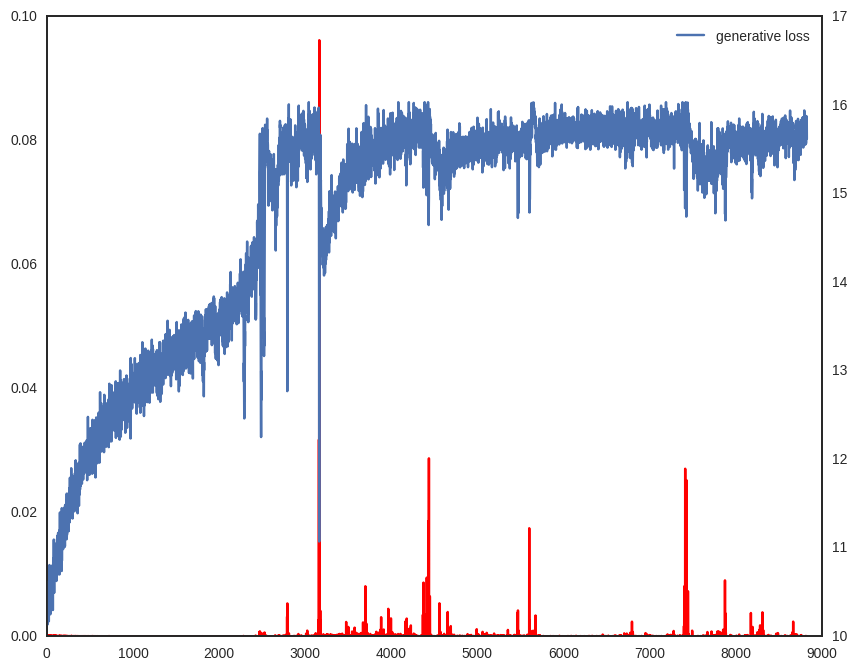

100%|██████████| 5000/5000 [40:17:09<00:00,  2.44it/s]


In [40]:
BATCH_SIZE = 32
nb_epoch = 5000
plt_frq = 25

for e in tqdm(range(nb_epoch)):
    
    # Make generative images
    image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
    noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
    generated_images = generator.predict(noise_gen)
    
    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE,2])
    y[0:BATCH_SIZE,1] = 1
    y[BATCH_SIZE:,0] = 1
    
    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)

    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
    y2 = np.zeros([BATCH_SIZE,2])
    y2[:,1] = 1
    
    #make_trainable(discriminator,False)
    g_loss = GAN.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)
    
    # Updates plots
    if e % plt_frq == 0:
        plot_loss(losses)
#         plot_gen()
